In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns
import mpl_toolkits.basemap as bm
import datetime
import dateutil
import csv
import os

# Plotting config
%pylab inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
ts_parser = lambda date_str: datetime.datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")  if pd.notnull(date_str) and date_str else None
df = pd.read_csv("bike_sharing.csv", sep=",", header=0, converters={"datetime": ts_parser})

df.insert(loc = 9, value = pd.Series([x.year for x in df["datetime"]]), column = "year")
df.insert(loc = 10, value = pd.Series([x.month for x in df["datetime"]]), column = "month")
df.insert(loc = 11, value = pd.Series([x.day for x in df["datetime"]]), column = "day")

hours = pd.Series([x.hour for x in df["datetime"]])
df.insert(loc = 12, value = hours, column = "hour")

mod_hours = []
for h in hours:
    if h >= 5:
        mod_hours.append(h - 5)
    else:
        mod_hours.append(h + 24 - 5)

'''
mod_hours: 5 часов утра -- 0, а дальше время растет до 4 часа ночи
(так зависимость от часов лучше воспринимать, потому что день людей
заканчивается не в 24 часа, а ночью)
'''    

df.insert(loc = 12, value = mod_hours, column = "mod_hour")

In [6]:
features = ["season", "holiday", "workingday", "weather", "temp", "atemp", "humidity", "windspeed", "year", 
            "month", "day", "hour", "casual", "registered", "count"]

def find_correlated_features(df, features):
    for i, feature_i in enumerate(features):
        for j, feature_j in enumerate(features):
                corr = df[feature_i].corr(df[feature_j])
                if i < j and abs (corr) > 0.9:
                    print "Correlated features: %s + %s -> %.2f" % (feature_i, feature_j, corr)
                
find_correlated_features(df, features)

Correlated features: season + month -> 0.97
Correlated features: temp + atemp -> 0.98
Correlated features: registered + count -> 0.97


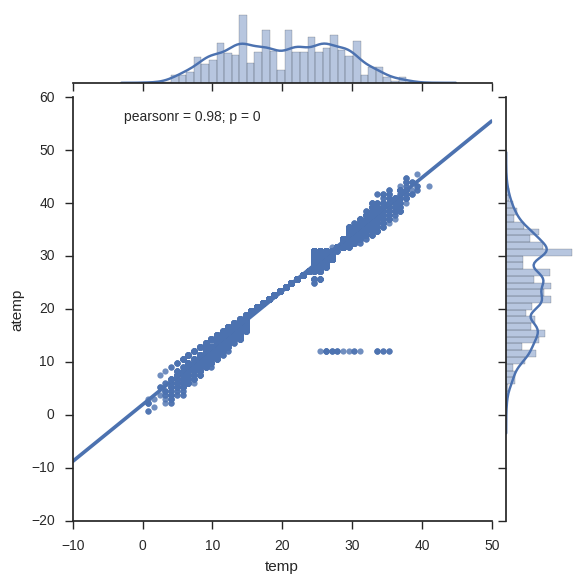

In [9]:
'''
Линейность зависимости между registered и count известна и так: count = registered + casual.

Зависимость month и season так же очевидна: month = (int) season / 4.

Линейная зависимость приведенной ощущаемой температуры от температуры не так очевидна, но поскольку
    она замечена, то не будет использовать temp в качестве feature, достаточно atemp.
'''
sns.set(style="ticks")
sns.jointplot("temp", "atemp", data=df, kind="reg")

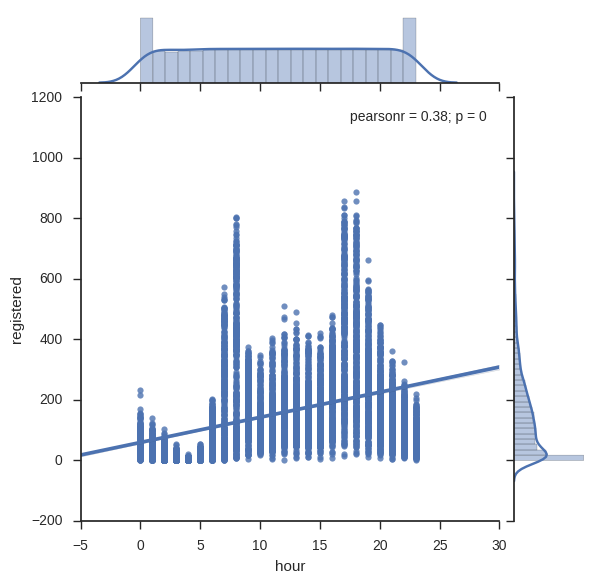

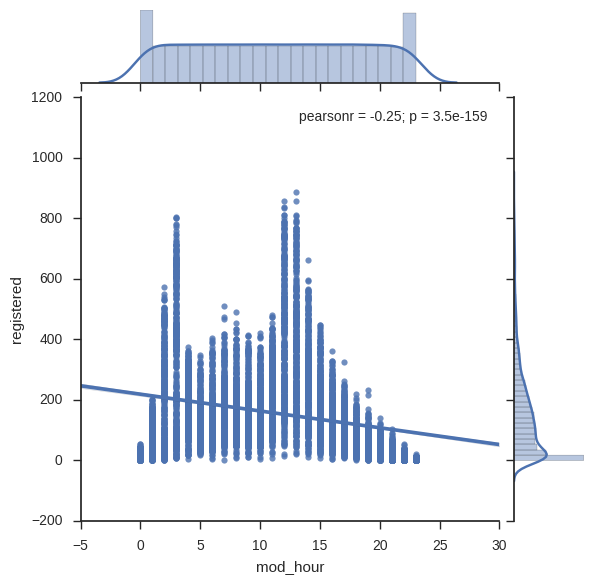

In [39]:
sns.jointplot("hour", "registered", data=df, kind="reg")
sns.jointplot("mod_hour", "registered", data=df, kind="reg")

# Гипотеза: registred чаще используют велосипеды, чтобы добираться на/c работы
#           Возможно, они чаще используют велосипеды в рабочие дни. Проверим это далее.
# registered = registered (mod_hour)

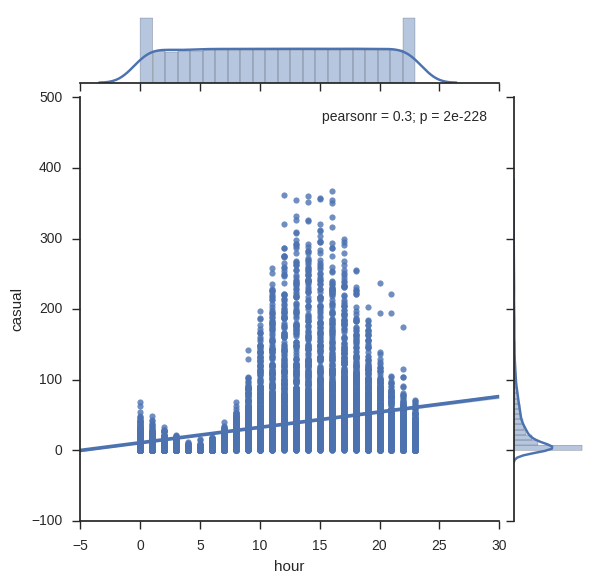

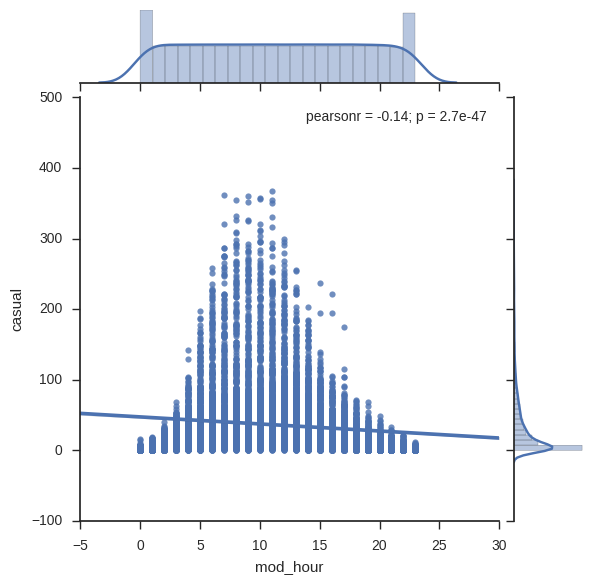

In [10]:
sns.jointplot("hour", "casual", data=df, kind="reg")
sns.jointplot("mod_hour", "casual", data=df, kind="reg")

# Гипотеза: casual используют прокат в свободное время в середине дня. 
#           Возможно, чаще в выходные дни. Проверим это далее.
# casual = casual (mod_hour)

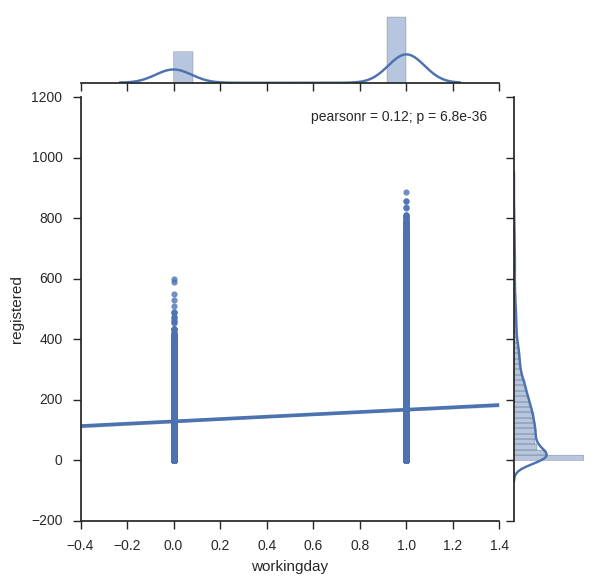

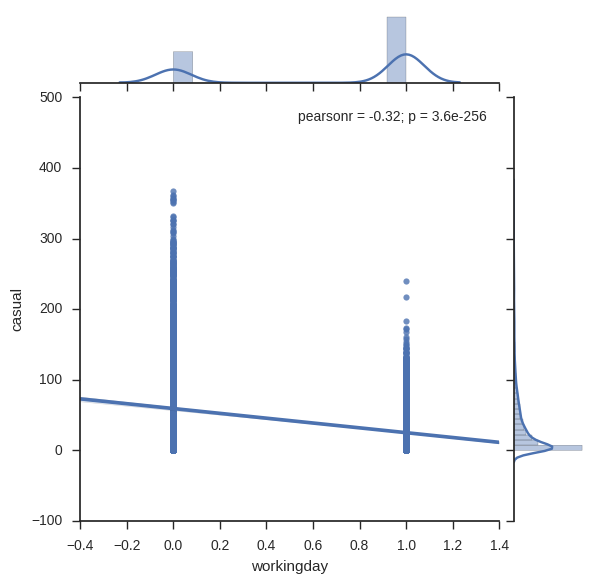

In [24]:
'''
Действительно, registered используют велосипеды чаще в рабочие дни, потому что едут на работы на них
    registered = registered (mod_hour, workingday).
Для casual предпочтительнее выходные, а не будние дни.
    casual = casual (mod_hour, workingday)
'''

sns.jointplot("workingday", "registered", data=df, kind="reg")
sns.jointplot("workingday", "casual", data=df, kind="reg")        

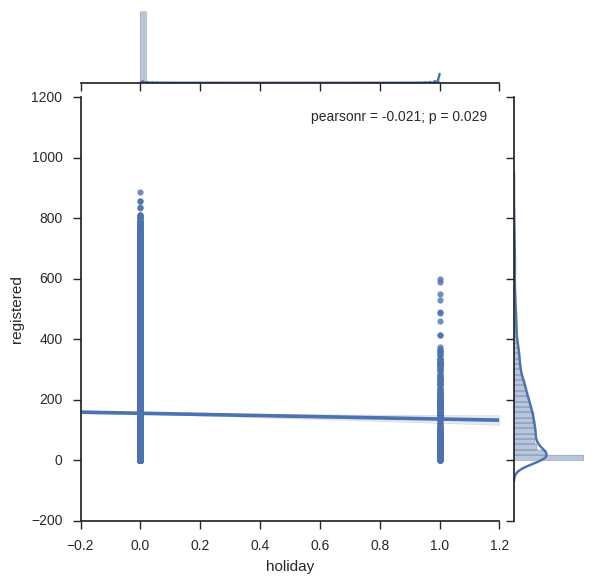

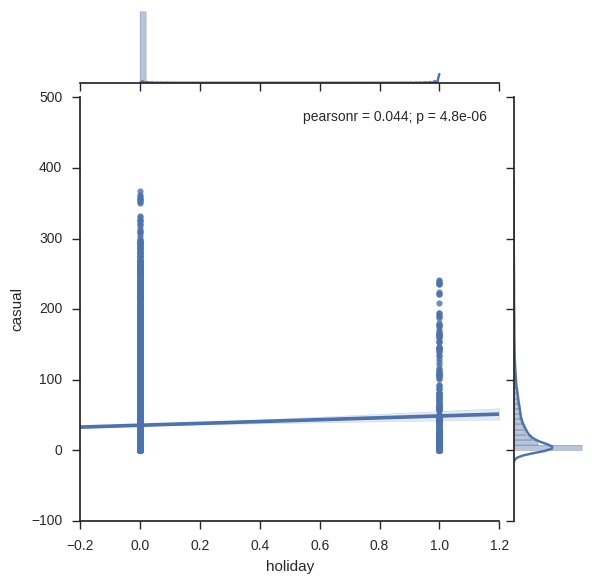

In [25]:
sns.jointplot("holiday", "registered", data=df, kind="reg")
sns.jointplot("holiday", "casual", data=df, kind="reg")

'''
Спад для обоих выборок в праздничные дни, можно предположить зависимость.
Поскольку праздничных дней очень мало, то их можно не рассматривать, уменьшив количество
независимых параметров (тем более working и holiday -- зависимые переменные)
'''

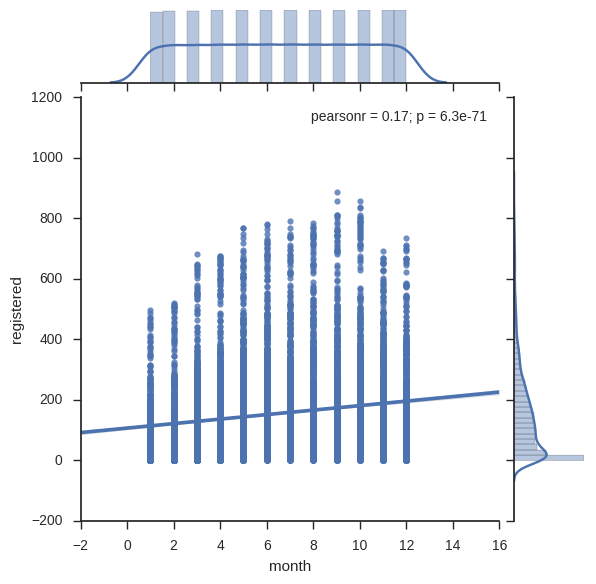

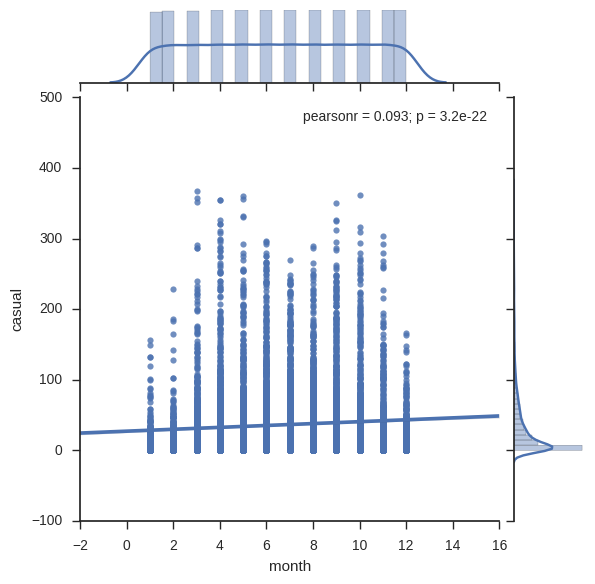

In [26]:
sns.jointplot("month", "registered", data=df, kind="reg")
sns.jointplot("month", "casual", data=df, kind="reg")

'''
Видна зависимость по месяцам (в холодные и жаркие месяцы виден спад), но
поскольку месяц влияет преимущественно через погодные условия, то можно не 
рассматривать зависимости от месяца. 
'''

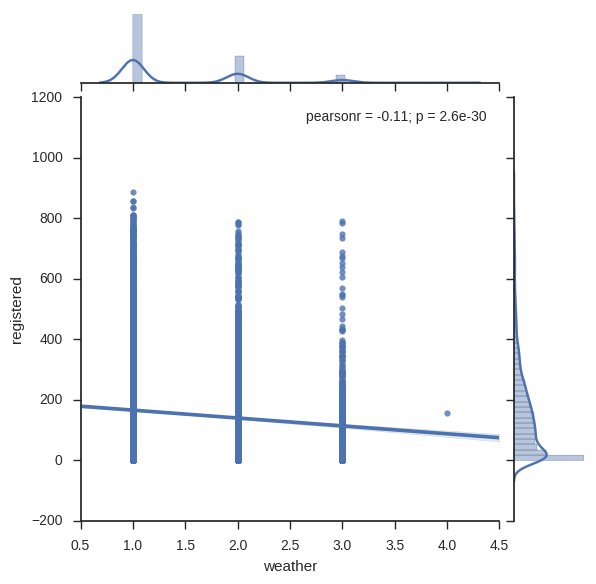

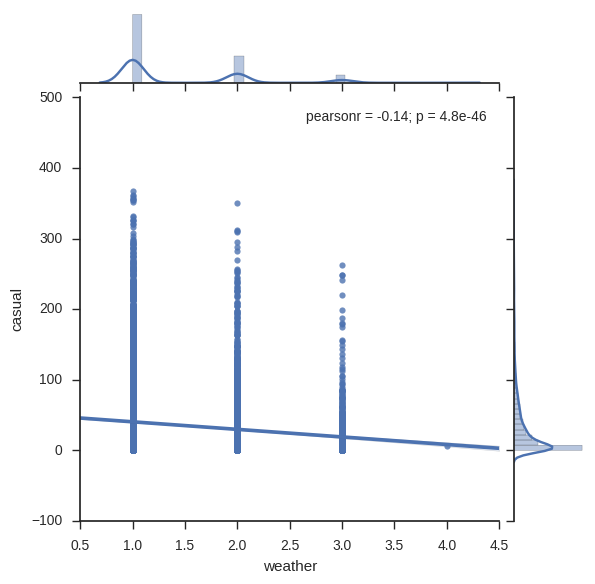

In [27]:
sns.jointplot("weather", "registered", data=df, kind="reg")
sns.jointplot("weather", "casual", data=df, kind="reg")

'''
Зависимость от погодных условий, очевидно, имеется. Но опять же, как и в случае с зависимостью
от месяца, погодные условия непосредственно вляют через температуру воздуха, влажность, скорости ветра
и так далее, т.е можно опять не рассматривать только зависимость через перечисленные величины.
'''

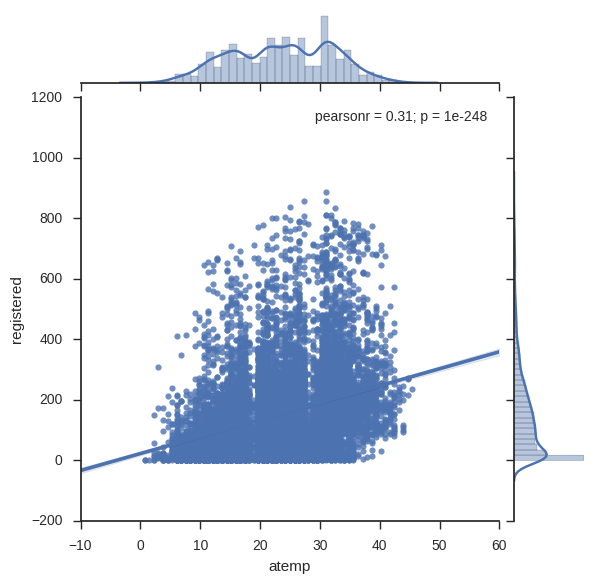

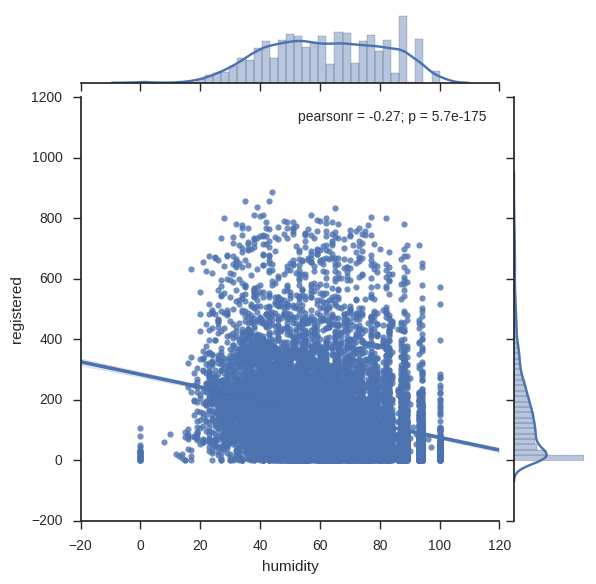

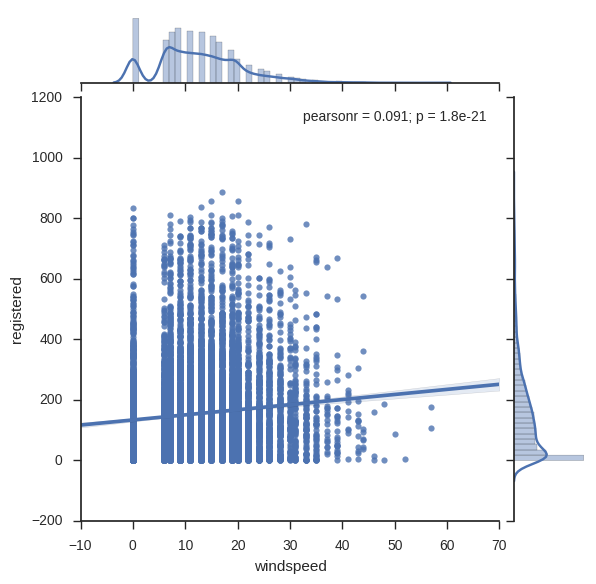

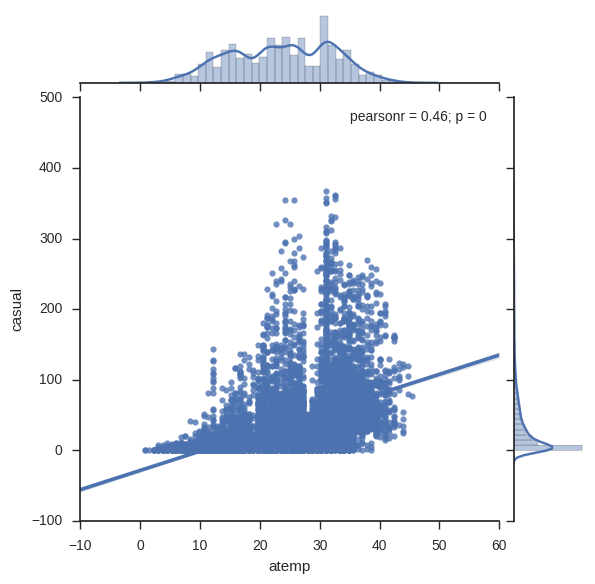

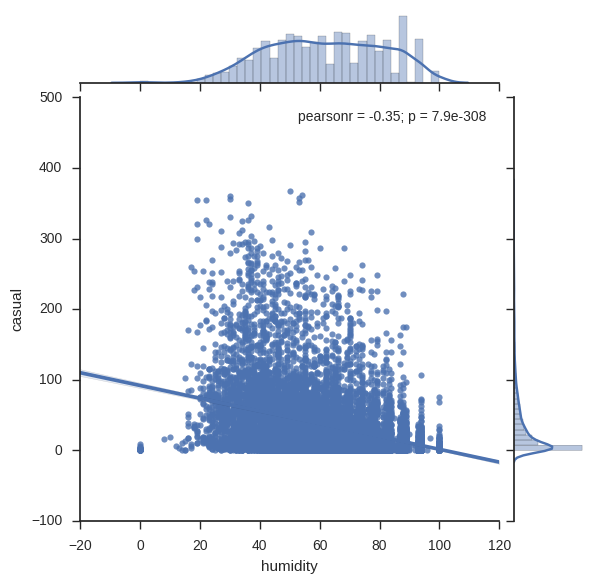

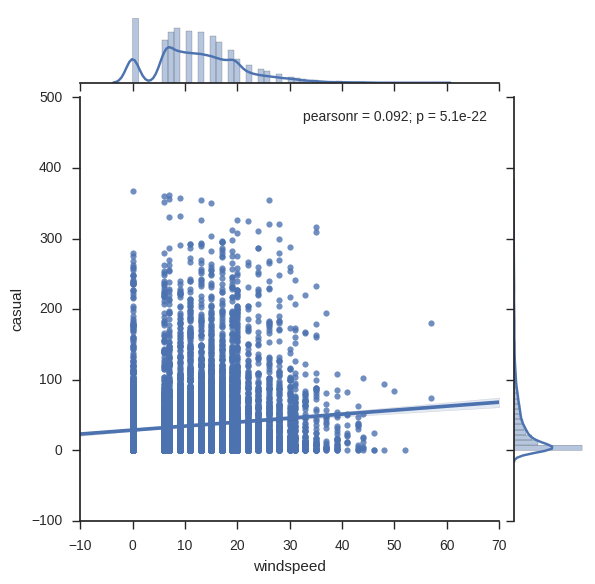

In [28]:
sns.jointplot("atemp", "registered", data=df, kind="reg")
sns.jointplot("humidity", "registered", data=df, kind="reg")
sns.jointplot("windspeed", "registered", data=df, kind="reg")

sns.jointplot("atemp", "casual", data=df, kind="reg")
sns.jointplot("humidity", "casual", data=df, kind="reg")
sns.jointplot("windspeed", "casual", data=df, kind="reg")

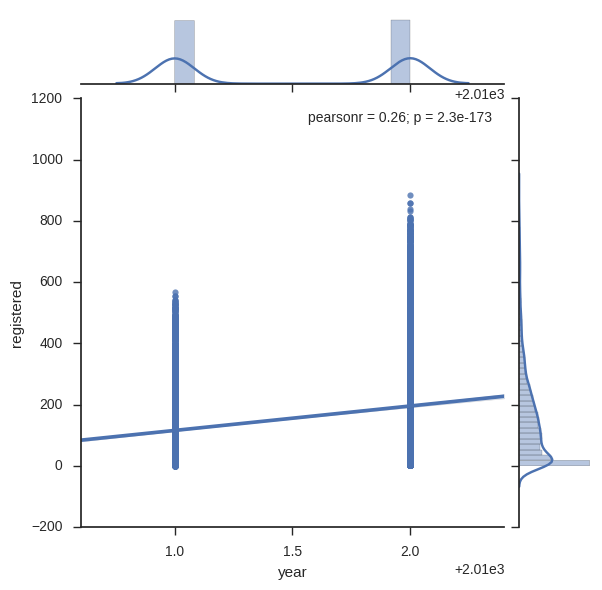

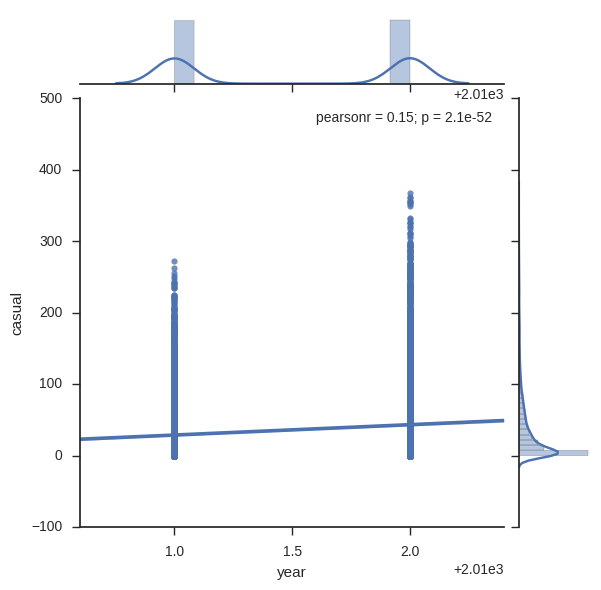

In [68]:
weather_features = ["atemp", "humidity", "windspeed"]
'''
Итак, можно проверить несколько регрессионных моделей:
    1) registered = registered (weather_features)
    2) registered = registered (mod_hour, workingday)
    3) registered = registered (workingday, weather_features)
    4) registered = registered (weather_features, mod_hour)
    
    1) casual = casual (weather_features)
    2) casual = casual (mod_hour, workingday)
    3) casual = casual (workingday, weather_features)
    4) casual = casual (weather_features, mod_hour)
    
Возможные отклонения от предпосылок:
• Модель неправильно специфицирована (можно только предполагать)
• Мультиколлинеаность (дисперсия ошибок неодинакова -- проверим)
• Гетероскедастичность (линейной зависимости между этими переменными -- проверим)
• Автокорреляция (временная корреляция между ошибками моделей существует, далее мы применим ARIMA)
'''

# временная зависимость мб существенна
sns.jointplot("year", "registered", data=df, kind="reg")
sns.jointplot("year", "casual", data=df, kind="reg")

In [65]:
from statsmodels.compat import lzip
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy.stats import linregress
from statsmodels.formula.api import ols
from statsmodels.formula.api import wls
from statsmodels.formula.api import gls

In [71]:
# Test 1 : registered = registered (weather_features)

formula_1 = 'registered ~ atemp + humidity + windspeed'
res_ols = smf.ols(formula=formula_1, data=df).fit()
print(res_ols.summary())

#Heteroskedasticity tests
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breushpagan(res_ols.resid, res_ols.model.exog)
print (lzip(name, test))

                            OLS Regression Results                            
Dep. Variable:             registered   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     708.4
Date:                Thu, 08 Dec 2016   Prob (F-statistic):               0.00
Time:                        22:52:48   Log-Likelihood:                -69096.
No. Observations:               10886   AIC:                         1.382e+05
Df Residuals:                   10882   BIC:                         1.382e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    136.7164      7.099     19.258      0.0

In [79]:
# Test 2 : registered = registered (mod_hour, workingday)

formula_2 = 'registered ~ mod_hour + workingday'
lm = smf.ols(formula=formula_2, data=df).fit()
print(lm.summary())

#Heteroskedasticity tests
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breushpagan(lm.resid, lm.model.exog)
print (lzip(name, test))

                            OLS Regression Results                            
Dep. Variable:             registered   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     462.2
Date:                Thu, 08 Dec 2016   Prob (F-statistic):          2.27e-193
Time:                        22:54:40   Log-Likelihood:                -69623.
No. Observations:               10886   AIC:                         1.393e+05
Df Residuals:                   10883   BIC:                         1.393e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    192.9026      3.380     57.075      0.0

In [80]:
# Test 3 : registered = registered (workingday, weather_features)

formula_3 = 'registered ~ workingday + atemp + humidity + windspeed'
lm = smf.ols(formula=formula_3, data=df).fit()
print(lm.summary())

#Heteroskedasticity tests
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breushpagan(lm.resid, lm.model.exog)
print (lzip(name, test))

                            OLS Regression Results                            
Dep. Variable:             registered   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     578.0
Date:                Thu, 08 Dec 2016   Prob (F-statistic):               0.00
Time:                        22:54:41   Log-Likelihood:                -69018.
No. Observations:               10886   AIC:                         1.380e+05
Df Residuals:                   10881   BIC:                         1.381e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    113.8739      7.282     15.638      0.0

In [81]:
# Test 4 : registered = registered (weather_features, mod_hour)

formula_4 = 'registered ~ mod_hour + atemp + humidity + windspeed'
lm = smf.ols(formula=formula_4, data=df).fit()
print(lm.summary())

#Heteroskedasticity tests
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breushpagan(lm.resid, lm.model.exog)
print (lzip(name, test))

                            OLS Regression Results                            
Dep. Variable:             registered   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     765.8
Date:                Thu, 08 Dec 2016   Prob (F-statistic):               0.00
Time:                        22:54:41   Log-Likelihood:                -68717.
No. Observations:               10886   AIC:                         1.374e+05
Df Residuals:                   10881   BIC:                         1.375e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    195.8406      7.174     27.299      0.0

In [82]:
# Test 5 : casual = casual (weather_features)

formula_5 = 'casual ~ atemp + humidity + windspeed'
lm = smf.ols(formula=formula_5, data=df).fit()
print(lm.summary())

#Heteroskedasticity tests
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breushpagan(lm.resid, lm.model.exog)
print (lzip(name, test))

                            OLS Regression Results                            
Dep. Variable:                 casual   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     1719.
Date:                Thu, 08 Dec 2016   Prob (F-statistic):               0.00
Time:                        22:54:41   Log-Likelihood:                -55912.
No. Observations:               10886   AIC:                         1.118e+05
Df Residuals:                   10882   BIC:                         1.119e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     24.3061      2.115     11.494      0.0

In [83]:
# Test 6 : casual = casual (mod_hour, workingday)

formula_6 = 'casual ~ mod_hour + workingday'
lm = smf.ols(formula=formula_6, data=df).fit()
print(lm.summary())

#Heteroskedasticity tests
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breushpagan(lm.resid, lm.model.exog)
print (lzip(name, test))

                            OLS Regression Results                            
Dep. Variable:                 casual   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     750.2
Date:                Thu, 08 Dec 2016   Prob (F-statistic):          6.09e-306
Time:                        22:54:41   Log-Likelihood:                -57321.
No. Observations:               10886   AIC:                         1.146e+05
Df Residuals:                   10883   BIC:                         1.147e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     70.8872      1.092     64.936      0.0

In [84]:
# Test 7 : casual = casual (workingday, weather_features)

formula_7 = 'casual ~ workingday + atemp + humidity + windspeed'
lm = smf.ols(formula=formula_7, data=df).fit()
print(lm.summary())

#Heteroskedasticity tests
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breushpagan(lm.resid, lm.model.exog)
print(lzip(name, test))

                            OLS Regression Results                            
Dep. Variable:                 casual   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     2078.
Date:                Thu, 08 Dec 2016   Prob (F-statistic):               0.00
Time:                        22:54:42   Log-Likelihood:                -54934.
No. Observations:               10886   AIC:                         1.099e+05
Df Residuals:                   10881   BIC:                         1.099e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     47.4815      1.997     23.778      0.0

In [85]:
# Test 8 : casual = casual (weather_features, mod_hour)

formula_8 = 'casual ~ mod_hour + atemp + humidity + windspeed'
lm = smf.ols(formula=formula_8, data=df).fit()
print(lm.summary())

#Heteroskedasticity tests
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breushpagan(lm.resid, lm.model.exog)
print(lzip(name, test))

                            OLS Regression Results                            
Dep. Variable:                 casual   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     1372.
Date:                Thu, 08 Dec 2016   Prob (F-statistic):               0.00
Time:                        22:54:42   Log-Likelihood:                -55801.
No. Observations:               10886   AIC:                         1.116e+05
Df Residuals:                   10881   BIC:                         1.116e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     33.9484      2.190     15.500      0.0

In [86]:
'''
Выводы по применению OLS:
1) Значимость регрессии пройден в каждом случае -- F-test;
2) Качество регрессии плохое (max R-squared = 0.433);
3) Significant non-normality -- Jarque-Bera, Omnibus tests;
4) Significant Multicollinearity -- Condition number test
5) Significant Heteroskedasticity -- Breush-Pagan test;

Практически все отклонения от предпосылок теоремы Гаусса-Маркова имеют место.
С мультиколлинеарностью ничего не сделать, поскольку это и так наименее коллинеарные данные.
С автокорреляцией поможет справиться ARIMА.
'''

'\n1) F-test \xd0\xbd\xd0\xb0 \xd0\xb7\xd0\xbd\xd0\xb0\xd1\x87\xd0\xb8\xd0\xbc\xd0\xbe\xd1\x81\xd1\x82\xd1\x8c \xd1\x80\xd0\xb5\xd0\xb3\xd1\x80\xd0\xb5\xd1\x81\xd1\x81\xd0\xb8\xd0\xb8 \xd0\xbf\xd1\x80\xd0\xbe\xd0\xb9\xd0\xb4\xd0\xb5\xd0\xbd \xd0\xb2 \xd0\xba\xd0\xb0\xd0\xb6\xd0\xb4\xd0\xbe\xd0\xbc \xd1\x81\xd0\xbb\xd1\x83\xd1\x87\xd0\xb0\xd0\xb5\n2) \xd0\xbe\xd0\xb4\xd0\xbd\xd0\xb0\xd0\xba\xd0\xbe \xd0\xba\xd0\xb0\xd1\x87\xd0\xb5\xd1\x81\xd1\x82\xd0\xb2\xd0\xbe \xd1\x80\xd0\xb5\xd0\xb3\xd1\x80\xd0\xb5\xd1\x81\xd1\x81\xd0\xb8\xd0\xb8 \xd0\xbf\xd0\xbb\xd0\xbe\xd1\x85\xd0\xbe\xd0\xb5 (max R-squared = 0.433).\n\xd0\x9f\xd1\x80\xd0\xb8\xd1\x87\xd0\xb8\xd0\xbd\xd0\xb0 -- \xd0\xb0\xd0\xb2\xd1\x82\xd0\xbe\xd0\xba\xd0\xbe\xd1\x80\xd1\x80\xd0\xb5\xd0\xbb\xd1\x8f\xd1\x86\xd0\xb8\xd1\x8f.\n'

In [5]:
%matplotlib inline

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import statsmodels.api as sm
plt.style.use('ggplot')

In [7]:
import datetime
ts_parser = lambda date_str: datetime.datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")  if pd.notnull(date_str) and date_str else None
df = pd.read_csv("bike_sharing.csv", sep=",", header=0, converters={"datetime": ts_parser})
def mean(df):
    t1 = 0
    t2 = 0
    t3 = 0
    casual = []
    registered = []
    count = []
    time = []
    for i in xrange(len(df)):
        t1 += df["casual"][i]
        t2 += df["registered"][i]
        t3 += df["count"][i]
        if df["datetime"][i].hour == 23:
            casual.append(t1)
            registered.append(t2)
            count.append(t3)
            t1 = 0
            t2 = 0
            t3 = 0
            time.append(datetime.datetime(df["datetime"][i].year, df["datetime"][i].month, df["datetime"][i].day))
            #time.append(str(df["datetime"][i].year) + "-" + str(df["datetime"][i].month) + "-" + str(df["datetime"][i].day))
    return casual, registered, count, time
casual, registered, count, time = mean(df)
#df['Date'] = pd.to_datetime(df['Date'])
data = pd.DataFrame(casual, pd.DatetimeIndex(start='1/1/2011',
                                      periods=len(casual),
                                      freq="D"), columns=["casual"])
data = data.astype("float64")
data.head()

,casual
2011-01-01,331.0
2011-01-02,131.0
2011-01-03,120.0
2011-01-04,108.0
2011-01-05,82.0


In [8]:
ts = data['casual']
ts.head(10)
ts.tail()

2012-03-27    767.0
2012-03-28    538.0
2012-03-29    212.0
2012-03-30    433.0
2012-03-31    333.0
Freq: D, Name: casual, dtype: float64

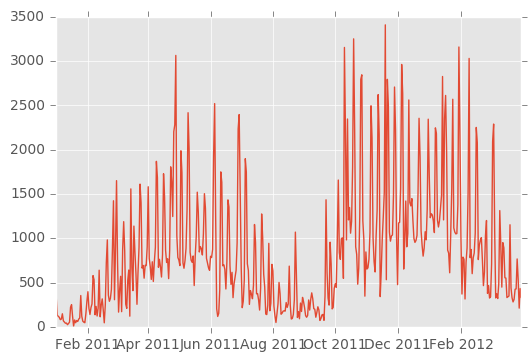

In [9]:
plt.plot(ts)

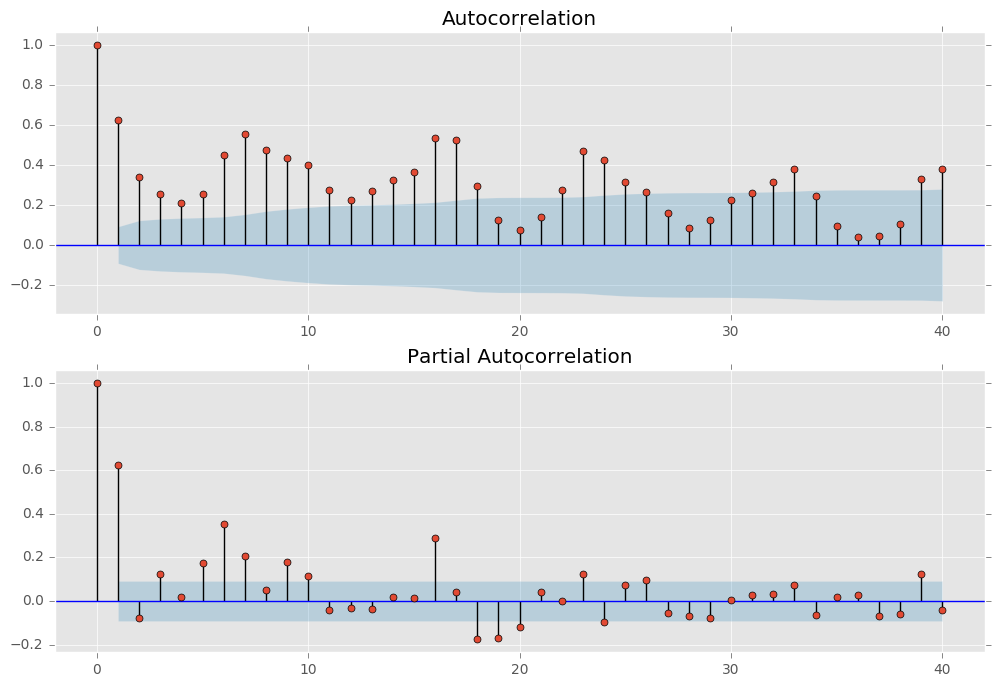

In [11]:
from statsmodels.graphics.api import qqplot

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)


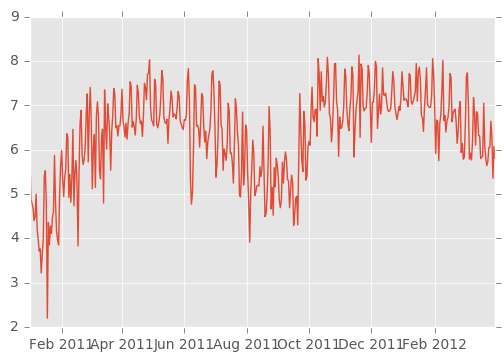

In [12]:
ts_log = np.log(ts)
plt.plot(ts_log)

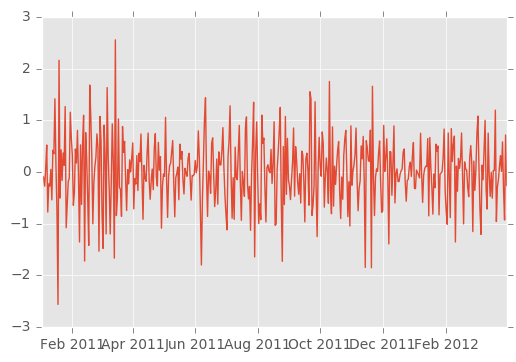

In [18]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
plt.plot(ts_log_diff)

### Тест Дики-Фуллера

In [13]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


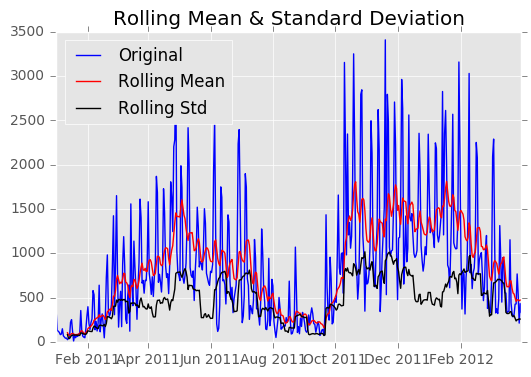

Results of Dickey-Fuller Test:
Test Statistic                  -2.201627
p-value                          0.205655
#Lags Used                      18.000000
Number of Observations Used    437.000000
Critical Value (5%)             -2.868177
Critical Value (1%)             -3.445403
Critical Value (10%)            -2.570305
dtype: float64


In [14]:
test_stationarity(ts)

## Оценка сезонности

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


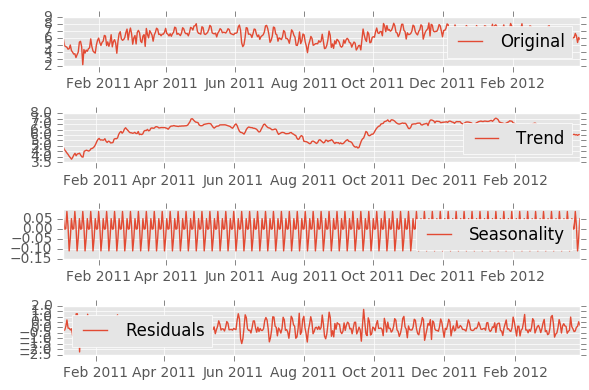

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts_log.index = pd.to_datetime(ts_log.index)
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


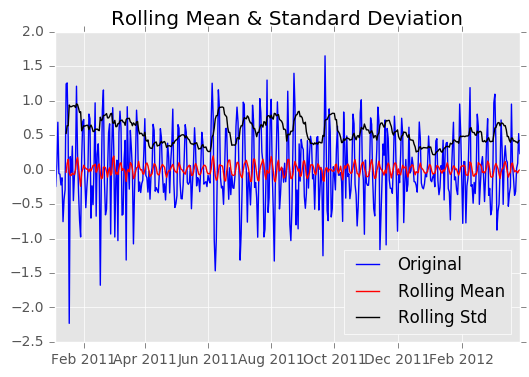

Results of Dickey-Fuller Test:
Test Statistic                -1.275883e+01
p-value                        8.227204e-24
#Lags Used                     1.500000e+01
Number of Observations Used    4.340000e+02
Critical Value (5%)           -2.868223e+00
Critical Value (1%)           -3.445508e+00
Critical Value (10%)          -2.570330e+00
dtype: float64


In [16]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

### Модель авторегресии AR

In [19]:
from statsmodels.tsa.arima_model import ARIMA
for i in xrange(10):
    model = ARIMA(ts_log, order=(i, 1, 0))  
    results_AR = model.fit(disp=-1)
    print i
    print 'RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2)

0
RSS: 201.1264
1
RSS: 199.0069
2
RSS: 185.2790
3
RSS: 176.5801
4
RSS: 167.4451
5
RSS: 149.1781
6
RSS: 144.0940
7
RSS: 141.3520
8
RSS: 139.8630
9
RSS: 137.7877


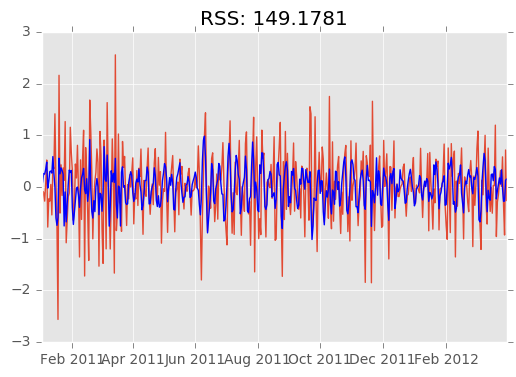

In [20]:
model = ARIMA(ts_log, order=(5, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='blue')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

### Модель скользящего среднего MA

In [21]:
for i in xrange(4):
    model = ARIMA(ts_log, order=(0, 1, i))  
    results_MA = model.fit(disp=-1)  
    print i
    print 'RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2)

0
RSS: 201.1264
1
RSS: 189.6705
2
RSS: 154.5003
3
RSS: 152.9139


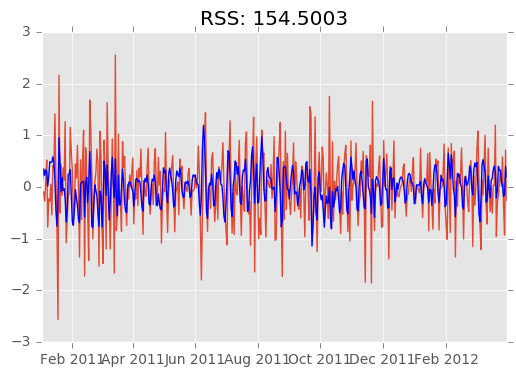

In [22]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='blue')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

### ARIMA = AR + MA + difference(y_t, I)

In [23]:
for p in range(6):
    for d in range(2):
        for q in range(4):
            try:
                model = sm.tsa.ARIMA(ts_log_decompose, order=(p, d, q))
                results = model.fit(method="mle")
                print p,d,q
            except:
                pass

0 0 0
0 0 1
0 0 2


/usr/local/lib/python2.7/dist-packages/statsmodels-0.8.0rc1-py2.7-linux-x86_64.egg/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0 0 3
0 1 0
0 1 1
0 1 2
1 0 0
1 0 1
1 1 0
2 0 0
2 1 0
3 0 0


/usr/local/lib/python2.7/dist-packages/statsmodels-0.8.0rc1-py2.7-linux-x86_64.egg/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 0 3
3 1 0
4 0 0
4 1 0
5 0 0


/usr/local/lib/python2.7/dist-packages/statsmodels-0.8.0rc1-py2.7-linux-x86_64.egg/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 0 1


/usr/local/lib/python2.7/dist-packages/statsmodels-0.8.0rc1-py2.7-linux-x86_64.egg/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 0 2


/usr/local/lib/python2.7/dist-packages/statsmodels-0.8.0rc1-py2.7-linux-x86_64.egg/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 0 3
5 1 0


In [24]:
model = sm.tsa.ARIMA(ts_log_decompose, order=(5, 0, 2))
fit = model.fit(method="mle")
fit.summary()

/usr/local/lib/python2.7/dist-packages/statsmodels-0.8.0rc1-py2.7-linux-x86_64.egg/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 casual   No. Observations:                  450
Model:                     ARMA(5, 2)   Log Likelihood                -167.485
Method:                           mle   S.D. of innovations              0.348
Date:                Fri, 09 Dec 2016   AIC                            352.970
Time:                        18:58:03   BIC                            389.953
Sample:                    01-04-2011   HQIC                           367.546
                         - 03-28-2012                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0001      0.000      0.999      0.318      -0.000       0.000
ar.L1.casual     0.4194      0.274      1.530      0.127      -0.118       0.956
ar.L2.casual    -0.3747      0.204     -1.834      0.067      -0.775       0.026
ar.L3.casual    -0.3391      0.144     -2.352      0.019      -0.622      -0.057
ar.L4.casual    -0.0020      0.062     -0.032      0.975      -0.124       0.120
ar.L5.casual    -0.2664      0.048     -5.583      0.000      -0.360      -0.173
ma.L1.casual    -0.7168      0.293     -2.449      0.015      -1.290      -0.143
ma.L2.casual    -0.2767      0.289     -0.958      0.339      -0.843       0.290
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.7557           -0.8325j            1.1244           -0.1327
AR.2            0.7557           +0.8325j            1.1244            0.1327
AR.3           -1.3938           -0.0000j            1.3938           -0.5000
AR.4           -0.0625           -1.4581j            1.4594           -0.2568
AR.5           -0.0625           +1.4581j            1.4594            0.2568
MA.1            1.0052           +0.0000j            1.0052            0.0000
MA.2           -3.5959           +0.0000j            3.5959            0.5000
-----------------------------------------------------------------------------
"""

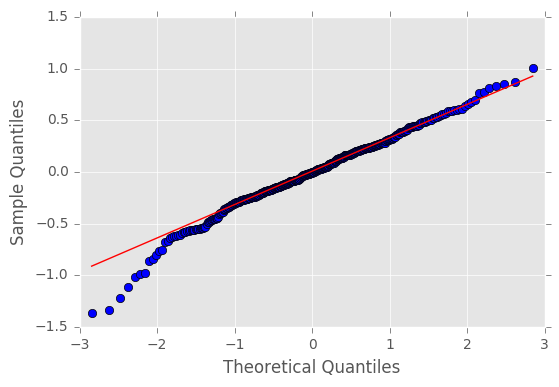

In [25]:
qqplot(fit.resid, line='q');